# Загрузка Pandas и очистка данных

In [440]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

RANDOM_SEED = 42

In [441]:
df_train = pd.read_csv('main_task.xls')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [442]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать,
# поэтому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [443]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [445]:
 df.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Как видим имеются пропуски в признаках: 'Cuisine Style', 'Price Range', 'Number of Reviews'

Далее заполняем пропуски в 'Cuisine Style'

In [446]:
df['Cuisine Style'].fillna('[]', inplace=True)

In [447]:
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x))

Генерируем признак кол-ва кухонь в каждом ресторане

In [448]:
df['Cuisine Style Number'] = df['Cuisine Style'].apply(lambda x: len(x) if len(x) > 0 else 1)

Далее заполняем пропуски в 'Number of Reviews'

In [449]:
df['Number of Reviews'].fillna(0, inplace=True)

Далее проанализируем пропуски в 'Price Range'

In [450]:
df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

заменим пропущенные значения из 'Price Range' на самый популярный диапазон и сгенерируем новый признак на основе 'Price Range'

In [451]:
df['Price Range'].fillna('$$ - $$$', inplace=True)

In [452]:
def extract_price(data):
    if (data == '$'):
        return 1
    elif (data == '$$ - $$$'):
        return 2
    else:
        return 3

df['Price Range Level'] = df['Price Range'].apply(extract_price)

Получим список городов по которым у нас есть данные

In [453]:
df['City'].unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

Добавим новые признаки на основании кол-ва туристов и кол-ва ресторанов в городах. Данные взяты из интернета.

In [454]:
visitors = {'Paris':40, 
'Stockholm':30.7, 
'London':67.6, 
'Berlin':13.5, 
'Munich':8.7, 
'Oporto':1.6, 
'Milan':9, 
'Bratislava':1.3, 
'Vienna':7.5, 
'Rome':15.2, 
'Barcelona':8, 
'Madrid':10.4,
'Dublin':11.2, 
'Brussels':17.6, 
'Zurich':11.8, 
'Warsaw':9.6, 
'Budapest':4.5, 
'Copenhagen':10,
'Amsterdam':19, 
'Lyon':6, 
'Hamburg':3.4, 
'Lisbon':25.9, 
'Prague':6.7, 
'Oslo':1.6,
'Helsinki':1.24, 
'Edinburgh':2, 
'Geneva':0.66, 
'Ljubljana':5.93, 
'Athens':5.7,
'Luxembourg':1.14, 
'Krakow':14}
df['Visitors'] = df['City'].apply(lambda x: visitors[x])

In [455]:
restaurants = {'Paris':44896, 
'Stockholm':2500, 
'London':18110, 
'Berlin':4560, 
'Munich':3534, 
'Oporto':2161, 
'Milan':8785, 
'Bratislava':1417, 
'Vienna':4593, 
'Rome':13721, 
'Barcelona':10000, 
'Madrid':6334,
'Dublin':431, 
'Brussels':4235, 
'Zurich':2000, 
'Warsaw':3491, 
'Budapest':2753, 
'Copenhagen':1500,
'Amsterdam':1337, 
'Lyon':2939, 
'Hamburg':3639, 
'Lisbon':6342, 
'Prague':6175, 
'Oslo':400,
'Helsinki':150, 
'Edinburgh':138, 
'Geneva':1000, 
'Ljubljana':500, 
'Athens':2305,
'Luxembourg':784, 
'Krakow':1499}
df['Restaurants'] = df['City'].apply(lambda x: visitors[x])

Добавим дополнительные признаки на основании 'Ranking'

In [456]:
df['Review Ranking'] = df['Ranking'] * df['Number of Reviews']

In [457]:
df['Cousine Ranking'] = df['Ranking'] / df['Cuisine Style Number']

In [458]:
total_cuisine = 0
cuisine_dict = {}

for lc in df['Cuisine Style']:
    if len(lc) == 0:
        total_cuisine += 1
        continue

    for cuisine in lc:
        c = cuisine.strip()
        total_cuisine += 1
        if c not in cuisine_dict:
            cuisine_dict[c] = 0
        cuisine_dict[c] += 1

In [459]:
print(total_cuisine)
print(len(cuisine_dict))

131266
125


Как видим у нас 125 типов кухонь, по ним можно сгенерировать dummy переменные, так же как и по 'City'

Сгенерируем dummy переменные на основе 'City' и 'Cuisine Style'

In [460]:
df = pd.concat([df.drop('City', axis=1), pd.get_dummies(df['City'])], axis=1)

In [461]:
mlb = MultiLabelBinarizer()
df = pd.concat([df.drop('Cuisine Style', axis=1), 
                pd.DataFrame(mlb.fit_transform(df['Cuisine Style']), columns=mlb.classes_)], axis=1)

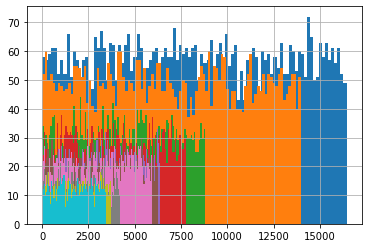

In [462]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

видим, что Ranking имеет нормальное распределение

Рассмотрим распределение целевой переменной

<AxesSubplot:>

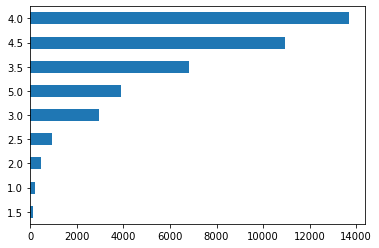

In [463]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Сопоставим города и рейтинги

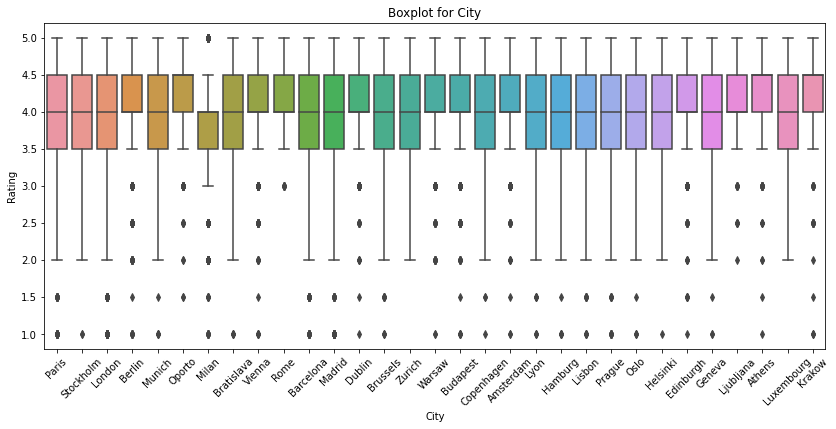

In [464]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x='City', y='Rating', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'City')
plt.show()

Видно, что среднее значение рейтинга 4.0, не зависит от города

Ранги ресторанов по городам

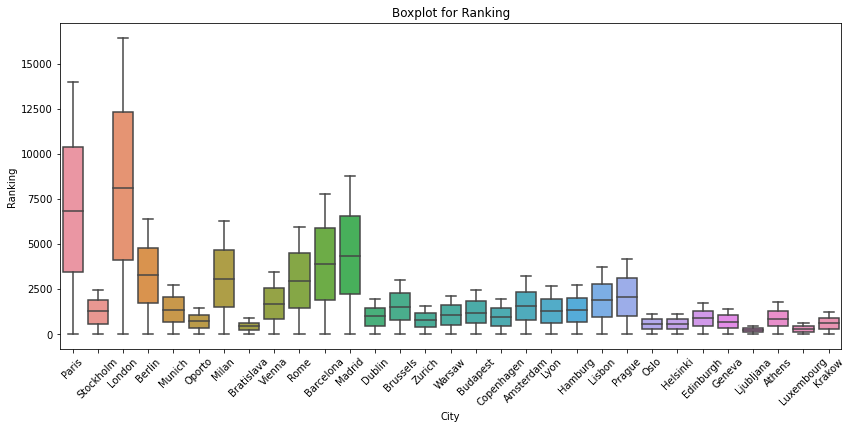

In [465]:
fig, ax = plt.subplots(figsize = (14, 6))
sns.boxplot(x='City', y='Ranking', data=df_train, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Boxplot for ' + 'Ranking')
plt.show()

Видно, что абсолютные значения ранга сильно зависят от количества ресторанов.

In [466]:
df = df.drop(columns=['Restaurant_id', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA'])

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [467]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

In [468]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['Rating'], axis = 1)
y = train_data['Rating']

In [469]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [470]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [471]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [472]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [473]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209983


In [474]:
test_data = test_data.drop(['Rating'], axis = 1)
predict_submission = regr.predict(test_data)
predict_submission = (predict_submission * 2).round() / 2
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('my_submission.csv', index=False)

In [475]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


В данном проекте был проанализирован и подготовлен к моделированию датасет с информацией по ресторанам от TripAdvisor. Работа заключалась в очистке данных, заполнении пропусков и создании новых признаков с целью уменьшить ошибку прогноза рейтинга ресторана. Категориальные признаки, по возможности, были переведены в числовой формат для использования в модели ML.

В датасете были обнаружены пропуски данных в признаках 'Number of Reviews', 'Price Range' и 'Cuisine Style'. Пропуски были заполнены.

Категориальный признак 'City' включает в себя 31 город. Признак был закодирован при помощи функции get_dummies.

Ордерный признак 'Price Range'- 3 градации - заменили последовательными числами 1,2,3. Больше всего ресторанов - в среднем ценовом диапазоне.

Категориальный признак 'Cuisine Style': в датасете 125 уникальных кухонь. На его основе создан новый признак с количеством кухонь в ресторане. На основании кухонь так же были добапвлены dummy переменные при помощи MultiLabelBinarizer.

Для создания новых признаков была найдена информация о кол-ве туристов в каждом городе и кол-ве ресторанов.

Было произведено моделирование с использованием алгоритма машинного обучения "RandomForestRegression". Округление результатов моделирования (до 0.5, как шаг 'Rating' в исходном датасете) уменьшило абсолютную ошибку. Метрика Mean Absolute Error показала отклонение MAE=0.209983 от фактических значений.